# Neural Style Transfer

### Neural style transfer is the art of creating style to any content.Content is the layout or the sketch and Style being the painting or the colors. It is an application of Image transformation using Deep Learning.

### In this project we will be using pretrained convolutional neural network model VGG19

# Importing the libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.models import Model


# Import the content image and style image

In [2]:
content_path = "../input/final-upload/Ea7vzHrU0AENF8X.jpg"
style_path = "../input/final-upload/The_Girl_With_A_Pearl_Earring_by_Johannes_Vermeer.jpg"

# Importing VGG19 model without the top layer or output layer which is softmax layer.

In [3]:
model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers
 
model.summary()

    

2022-08-07 05:18:21.738126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:21.873268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:21.874083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 05:18:21.875326: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

# Preprocess the image

In [4]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

## perform the inverse of the pre processing step

In [5]:
def deprocess(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]
 
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
 
    img = deprocess(img)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

## display the images

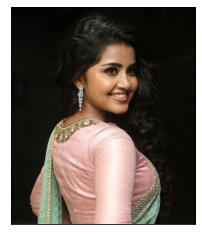

In [6]:
content_img = load_and_process_image(content_path)
display_image(content_img)



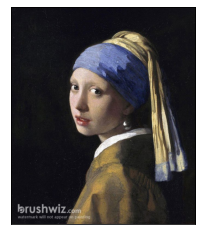

In [7]:
style_img = load_and_process_image(style_path)
display_image(style_img)

# Create the model

In [8]:
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# define style model

In [9]:
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

# define the loss functions

In [10]:
def content_loss(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

# define gram matrix

In [11]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


def style_cost(style, generated):
    J_style = 0
 
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight_of_layer
 
    return J_style

# Compile the model

In [12]:
generated_images = []

def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
    # load content and style images from their respective path
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)
 
    opt = tf.keras.optimizers.Adam(learning_rate=7)
 
    best_cost = float('inf')
    best_image = None
    for i in range(iterations):
        %time
        with tf.GradientTape() as tape:
            J_content = content_loss(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
 
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
 
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
 
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())
 
    return best_image


# Train the model

In [13]:
final_img = training_loop(content_path, style_path)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


2022-08-07 05:18:28.225203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Iteration :0
Total Loss 2.232243e+10.
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Iteration :1
Total Loss 2.161921e+10.
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Iteration :2
Total Loss 1.329091e+10.
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Iteration :3
Total Loss 1.019216e+10.
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Iteration :4
Total Loss 8.137276e+09.
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs
Iteration :5
Total Loss 6.263203e+09.
CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 16.5 µs
Iteration :6
Total Loss 5.172008e+09.
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Iteration :7
Total Loss 4.180346e+09.
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs
Iteration :8
Total Loss 3.477763e+09.
CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 16.7 µs
Iteration :9
Total Loss 2.861246e+09.
CPU times: user 4 µs, sys: 1 µs, total: 5 

# Output the result

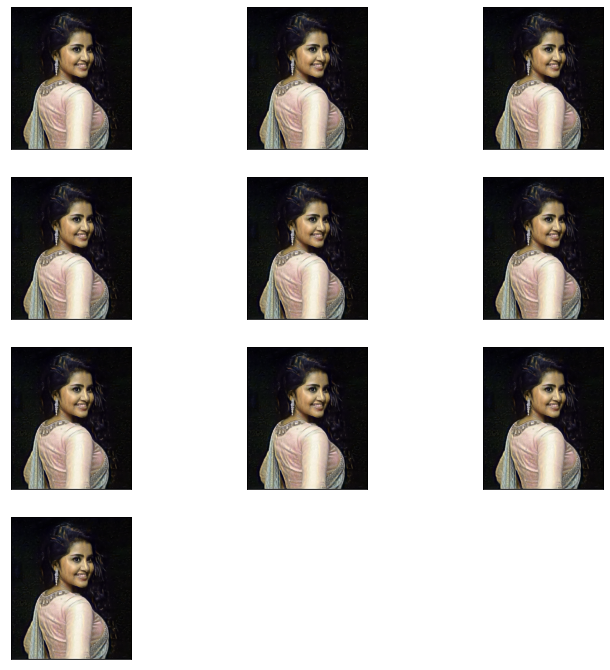

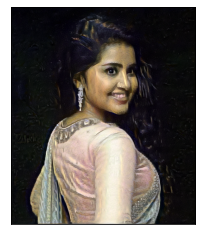

In [14]:
plt.figure(figsize=(12, 12))
 
for i in range(10):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[i+39])
plt.show()
 
# plot best result
display_image(final_img)